In [1]:
import torch
import pyro.distributions as dist
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx

### fastRG graph sampling (https://arxiv.org/pdf/1703.02998.pdf)
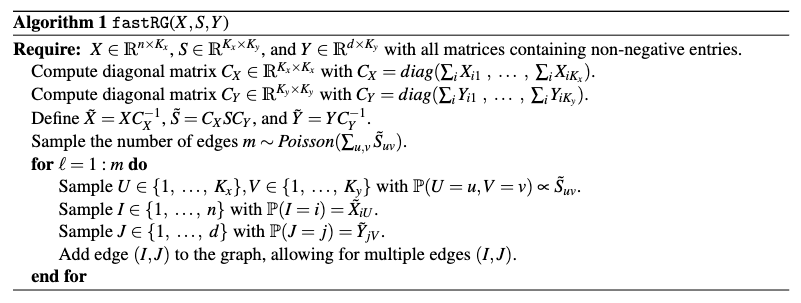

In [2]:
# random inputs
X = dist.OneHotCategorical(torch.Tensor([0.33, 0.33, 0.34])).sample([10])
S = torch.rand([3, 3])
Y = X
X, S, Y

(tensor([[0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 1.]]),
 tensor([[0.7919, 0.2514, 0.9122],
         [0.4838, 0.8794, 0.1357],
         [0.7357, 0.6195, 0.7618]]),
 tensor([[0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., 0., 1.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 0., 1.]]))

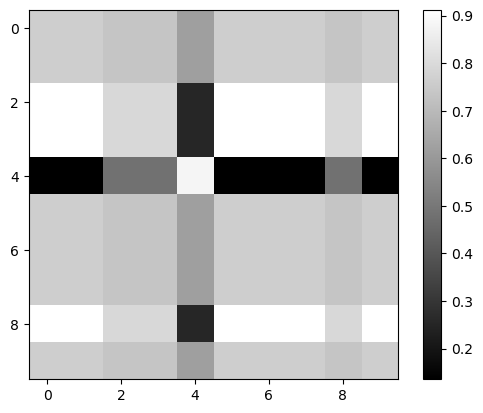

In [33]:
# expectation
plt.imshow(torch.mm(X, torch.mm(S, X.T)), cmap=plt.cm.gray)
plt.colorbar()

In [4]:
# membership degree matrices
CX = torch.diag(X.sum(0))
CY = torch.diag(Y.sum(0))
CY, CX

(tensor([[3., 0., 0.],
         [0., 1., 0.],
         [0., 0., 6.]]),
 tensor([[3., 0., 0.],
         [0., 1., 0.],
         [0., 0., 6.]]))

In [5]:
# membership probabilities
Xtilde = torch.mm(X, torch.inverse(CX))
Ytilde = torch.mm(Y, torch.inverse(CY))

# block degree matrix
Stilde = torch.mm(CX, torch.mm(S, CY))

Xtilde, Stilde, Ytilde

(tensor([[0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.1667],
         [0.3333, 0.0000, 0.0000],
         [0.3333, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.1667],
         [0.3333, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667]]),
 tensor([[ 7.1270,  0.7542, 16.4205],
         [ 1.4514,  0.8794,  0.8141],
         [13.2423,  3.7173, 27.4244]]),
 tensor([[0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.1667],
         [0.3333, 0.0000, 0.0000],
         [0.3333, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.1667],
         [0.0000, 0.0000, 0.1667],
         [0.3333, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1667]]))

In [28]:
# sample number of edges with total block degree expectation
m = dist.Poisson(Stilde.sum()).sample()
int(m)

78

In [29]:
# source-sink block selections
q = dist.Multinomial(probs=Stilde.ravel()).sample([int(m)]).reshape([int(m), 3,3])
q

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.]],

        [[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 1., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.]],

      

In [30]:
# source ids:
sources = dist.Categorical(torch.matmul(Xtilde, q).sum(-1)).sample()
# sink ids:
sinks   = dist.Categorical(torch.matmul(q, Ytilde.T).sum(1)).sample()
# edge list:
edges = torch.stack([sources, sinks])
edges

tensor([[6, 7, 5, 2, 0, 9, 2, 1, 5, 9, 7, 6, 9, 9, 8, 8, 4, 5, 5, 0, 2, 2, 1, 1,
         7, 0, 9, 3, 1, 9, 6, 1, 8, 1, 3, 2, 1, 7, 3, 1, 5, 2, 8, 2, 2, 3, 0, 8,
         2, 4, 3, 2, 5, 8, 3, 0, 1, 0, 8, 5, 5, 5, 4, 1, 5, 0, 9, 6, 0, 4, 6, 1,
         6, 9, 0, 0, 9, 7],
        [4, 1, 5, 6, 3, 0, 8, 8, 4, 0, 4, 8, 1, 1, 2, 9, 4, 5, 6, 1, 5, 2, 9, 2,
         8, 5, 8, 3, 7, 7, 2, 0, 0, 8, 5, 5, 5, 5, 7, 0, 6, 3, 2, 7, 5, 0, 6, 7,
         0, 5, 8, 7, 9, 7, 8, 7, 6, 9, 9, 4, 7, 3, 4, 3, 8, 1, 2, 1, 1, 4, 9, 9,
         7, 2, 5, 4, 9, 5]])

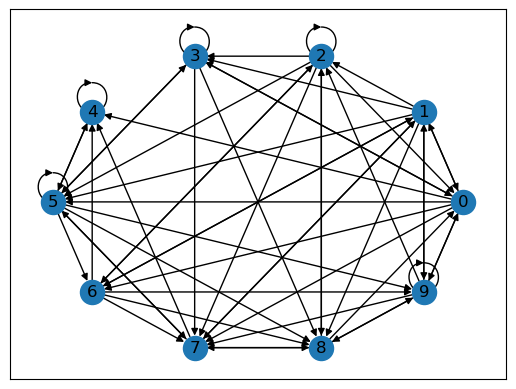

In [31]:
G = to_networkx(Data(edge_index=edges, num_nodes=10))
nx.draw_networkx(
    G,
    pos=nx.circular_layout(G)
)